In [43]:
### import required libraries
import itertools
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set_context('notebook')
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

In [44]:
### read credit card data and transactions data
cc_data = pd.read_csv('cc_info.csv', index_col = 'credit_card')
transac_data = pd.read_csv('transactions.csv')

print(cc_data.head(), '/n')
print(transac_data.head())

                      city state  zipcode  credit_card_limit
credit_card                                                 
1280981422329509    Dallas    PA    18612               6000
9737219864179988   Houston    PA    15342              16000
4749889059323202    Auburn    MA     1501              14000
9591503562024072   Orlando    WV    26412              18000
2095640259001271  New York    NY    10001              20000 /n
        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat  
0 -80.174132  40.267370  
1 -80.194240  40.180114  
2 -80.211033  40.313004  
3 -80.174138  40.290895  
4 -80.238720 

In [45]:
## convert to pandas datetime
transac_data['date'] = pd.to_datetime(transac_data.date)

# Q-1 : Your boss wants to identify those users that in your dataset never went above 
###   the monthly credit card limit (calendar month).
####   The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [47]:
###look at counts for the whole year
transac_data.date.dt.year.value_counts()

2015    294588
Name: date, dtype: int64

In [48]:
### group by $-amount per month
def monthly(df):
    return df.groupby(df.date.dt.month)['transaction_dollar_amount'].agg('sum')

In [49]:
## credit card montlhy spends
cc_monthly_spends = transac_data.groupby('credit_card').apply(monthly).unstack(fill_value = 0)


In [50]:
##join with crdit limit
cc_monthly_spends = cc_monthly_spends.join(cc_data.credit_card_limit)
cc_monthly_spends.head()

,7,8,9,10,credit_card_limit
credit_card,,,,,
1003715054175576,162.56,8441.51,11281.56,8954.21,20000
1013870087888817,281.43,11981.15,12461.96,12090.34,15000
1023820165155391,943.26,22741.20,18108.12,19259.98,28000
1073931538936472,220.07,2991.05,2557.12,1638.03,10000
1077622576192810,0.00,634.61,551.28,604.84,10000


In [38]:
### check each user has exceede his limit 
num_months = cc_monthly_spends.shape[1]-1
print(num_months)

def limit_exceed(p):
    lim = p.loc['credit_card_limit']
    return (p.iloc[0:num_months]<= lim).all()

cust_lim_exceed = cc_monthly_spends.apply(limit_exceed, axis = 1)
cust_lim_not_exceed = cc_monthly_spends.loc[cust_lim_exceed, :].index

cust_lim_not_exceed

4


Int64Index([1003715054175576, 1013870087888817, 1023820165155391,
            1073931538936472, 1077622576192810, 1087468642191606,
            1089479586475600, 1101164752077181, 1107936587129946,
            1126571863414211,
            ...
            9854872265114976, 9855217884613002, 9867492085978660,
            9884182241594028, 9938969980242308, 9946917923319410,
            9958678964376192, 9961694231875562, 9981251982982618,
            9986135779184360],
           dtype='int64', name='credit_card', length=862)

# Q-2 : On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit,
### it triggers an alert so that the user can be notiﬁed about that.
### We assume here that at the beginning of the new month, 
###user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). 
###Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [54]:
### fucntion to know limit of a day
class montlhyspent():
    def __init__(self,cc_limit):
        self.total_spent = defaultdict(float)
        self.cc_limit = cc_limit
    def reset(self):
        self.total_spent.clear()
    
    def count(self, daily_transactions):
        for cc_num, amount in daily_transactions:
            self.total_spent[cc_num] +=amount
        for cc_num , toatl in self.total_spent.viewitems():
            if total > self.cc_limit[cc_num]:
                return cc_num

# Q-3 Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies.
#### She wants you to implement an unsupervised algorithm  
### that returns all transactions that seem unusual and are worth being investigated further.

In [52]:
### see what the statistics of dolar amount 
def cc_stats(s):
    per = [25,50,75]
    d = np.percentile(s,per)
    return pd.Series(d,index = ['{}%'.format(p) for p in per])
transactions = transac_data.groupby('credit_card')['transaction_dollar_amount'].apply(cc_stats).unstack()
    

In [53]:
transactions.head()

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83
1073931538936472,108.08,147.19,194.83
1077622576192810,122.93,148.18,160.11


In [58]:
### merge with consumption stats
prev_consptn = pd.merge(transac_data,transactions,how = 'left',left_on = 'credit_card',right_index = True)

### merge with cc_limit
cc_limit_concat = pd.merge(prev_consptn,cc_data.loc[:,['credit_card_limit']], how= 'left',left_on='credit_card',right_index=True)
cc_limit_concat.tail()

,credit_card,date,transaction_dollar_amount,Long,Lat,25%,50%,75%,credit_card_limit
294583,9999757432802760,2015-09-10 19:43:33,127.23,-82.360952,32.978497,83.74,130.94,177.905,6000
294584,9999757432802760,2015-08-06 21:00:13,84.90,-82.322721,33.061071,83.74,130.94,177.905,6000
294585,9999757432802760,2015-09-22 16:15:47,77.54,-82.442130,32.949983,83.74,130.94,177.905,6000
294586,9999757432802760,2015-08-27 18:08:24,144.05,-82.398587,32.976162,83.74,130.94,177.905,6000
294587,9999757432802760,2015-08-22 00:14:52,154.36,-82.389680,33.068351,83.74,130.94,177.905,6000


In [59]:
cc_limit_concat.to_csv('tran_history.csv', index = False)


# reducing dimensions by considering only few features

In [62]:
X = cc_limit_concat.loc[:,['transaction_dollar_amount','25%','50%','75%','credit_card_limit']]
X.describe()

,transaction_dollar_amount,25%,50%,75%,credit_card_limit
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716
std,124.655954,21.471896,35.160028,49.919646,7956.291556
min,0.010000,6.150000,7.320000,9.120000,2000.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000
50%,58.470000,40.595000,65.190000,91.832500,15000.000000
75%,100.400000,56.215000,89.710000,127.345000,20000.000000
max,999.970000,137.690000,222.290000,318.730000,55000.000000


        pc1       pc2
0  1.184559 -0.583757
1  1.277856 -0.117918
2  1.192055 -0.546330
3  1.329760  0.141247
4  1.228622 -0.363745


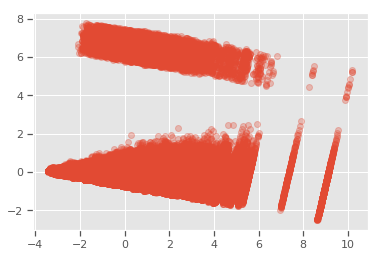

In [71]:
X = scale(X)
### pca to reduce feature matrix dimensions
pca = PCA(n_components = 2)## 2d graph
Xd = pca.fit_transform(X)
Xd = pd.DataFrame(Xd,columns =['pc1','pc2'])
print(Xd.head())

plt.scatter(Xd.pc1,Xd.pc2,alpha = 0.3)

In [73]:
### cluster using Kmeans , as we see from pca plot that we can cluster into meaningful clusters
n_clusters = 6
kmeans = KMeans(n_clusters = n_clusters,n_jobs = 1)
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [75]:
Xd['label'] = kmeans.labels_
print(Xd.label.value_counts())

0    107677
1     73495
4     49119
5     33034
2     25827
3      5436
Name: label, dtype: int64


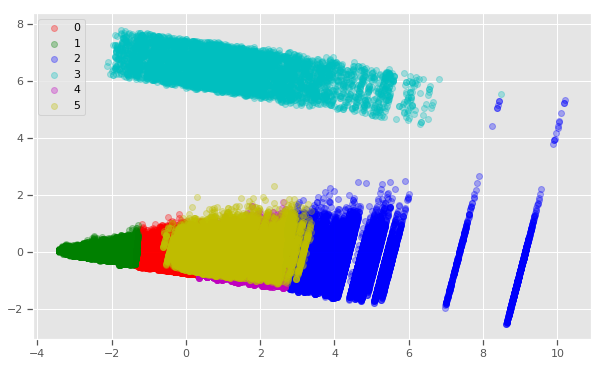

In [80]:
#### cluster no.3 has few transactions comapred to others --- BAMMM --- FRAUD
### plot to check the distribution of clusters

colors = itertools.cycle(['r','g','b','c','m','y','k'])
plt.rc('figure',figsize = (10,6))
for label in range(n_clusters):
    clust_dist = Xd.loc[Xd.label==label, :]
    plt.scatter(clust_dist.pc1,clust_dist.pc2, c = next(colors),label = label,alpha = 0.3)
plt.legend(loc = 'best')

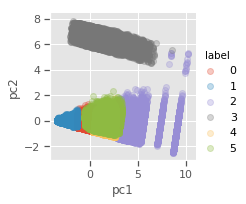

In [84]:
grid = sns.FacetGrid(Xd,hue = 'label')
grid.map(plt.scatter, 'pc1','pc2',alpha = 0.3)
grid.add_legend()

In [86]:
### check for fraud labels
fraud_label = Xd.label.value_counts().argmin()

fraud_label

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


3

In [92]:
fraud = cc_limit_concat.loc[Xd.label==fraud_label, ['credit_card','transaction_dollar_amount','25%','50%','75%',
                                                    'credit_card_limit','date']]

fraud.sample(10)

,credit_card,transaction_dollar_amount,25%,50%,75%,credit_card_limit,date
95381,3929517687134990,958.12,36.9475,60.615,80.615,10000,2015-08-22 20:56:46
136254,5098511582643613,845.49,40.6800,68.430,94.280,14000,2015-10-13 02:17:09
207792,7198750113791865,800.67,31.6800,48.310,67.690,3000,2015-09-22 22:45:50
186696,6497866359354370,943.32,16.0300,24.850,34.475,5000,2015-10-29 21:23:29
293098,9946917923319410,907.63,43.6100,76.230,102.640,15000,2015-09-26 19:18:37
105441,4172354071638301,829.93,56.1050,89.710,127.345,25000,2015-08-18 23:38:49
114457,4339853010378399,958.28,18.9450,30.670,41.540,18000,2015-09-14 19:17:44
178869,6239589776969686,939.84,68.5800,105.090,145.460,20000,2015-08-20 22:28:11
177467,6216751190381521,853.93,52.9400,87.440,126.370,10000,2015-09-24 22:15:33
207202,7193900293112316,924.29,67.9050,106.060,148.055,24000,2015-10-15 21:12:39


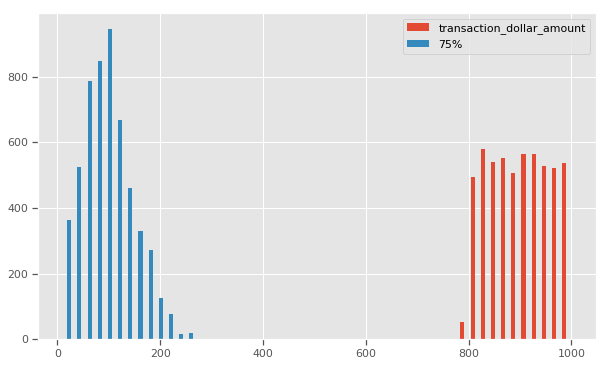

In [95]:
labels = ['transaction_dollar_amount','75%']
plt.hist(fraud.loc[:,labels].values,bins = 50,label = labels)
plt.legend(loc = 'best')

In [ ]:
### users transaction was suspicous as it is much higher than 75 percentile